In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline

In [2]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/vlado/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Classify news with Standard Machine Learning

Here, opposite to the other draft notebook, we will train standard classifiers. By standard I mean not neural networks.

In [3]:
df = pd.read_csv('archive/inshort_news_data-1.csv')
df.shape

(4817, 4)

In [4]:
for i in range(2, 8):
  df_train = pd.read_csv(f'archive/inshort_news_data-{i}.csv')
  df = df.append(df_train, ignore_index = True)
    
df.shape

(12120, 4)

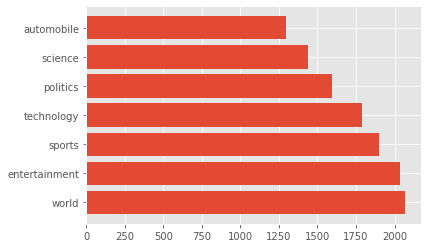

In [5]:
plt.figure(figsize=[6,4])
plt.barh(df['news_category'].value_counts().index, df['news_category'].value_counts());

We are going to have to clean the junk out of the text.

In [6]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'\d', '', text)
    text = text.strip(' ')
    return text

def remove_stopwords(row):
    final_row = [w for w in row.split(' ') if w not in stopwords.words('english')]
    final_row = ' '.join(final_row)
    return final_row


In [7]:
df['news_article'] = df['news_article'].map(clean_text)
df['news_article'] = df['news_article'].map(remove_stopwords)

In [8]:
df.sample(1)

,Unnamed: 0,news_headline,news_article,news_category
6927,547,India's highest ODI and T20I totals came at th...,india achieved highest ever ti total scoring ...,sports


## Tf-IDF

Here we use Tf IDf which is a method based mainly on the frequency of the words. It's very good with the simpler models that we will be creating  here. 

In [9]:
vectorizer = TfidfVectorizer()
x_train = vectorizer.fit_transform(df['news_article'])

In [10]:
x_train = x_train.toarray()

In [11]:
df['news_category'] = df['news_category'].map({'automobile': 0, 'science': 1, 'politics': 2, 'technology': 3, 'sports': 4, 'entertainment': 5, 'world': 6})
y_train = df['news_category'] 

In [12]:
x_train.shape, y_train.shape

((12120, 19853), (12120,))

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [14]:
x_train.shape, y_train.shape

((9696, 19853), (9696,))

In [15]:
x_test.shape, y_test.shape

((2424, 19853), (2424,))

## Naive Bayes

Very good with text data, sparse matrices and tf-idf.

In [16]:
nb = ComplementNB()

In [17]:
nb.fit(x_train, y_train)

ComplementNB()

In [18]:
predictions = nb.predict(x_test)

In [19]:
conf_matrix = confusion_matrix(predictions, y_test)

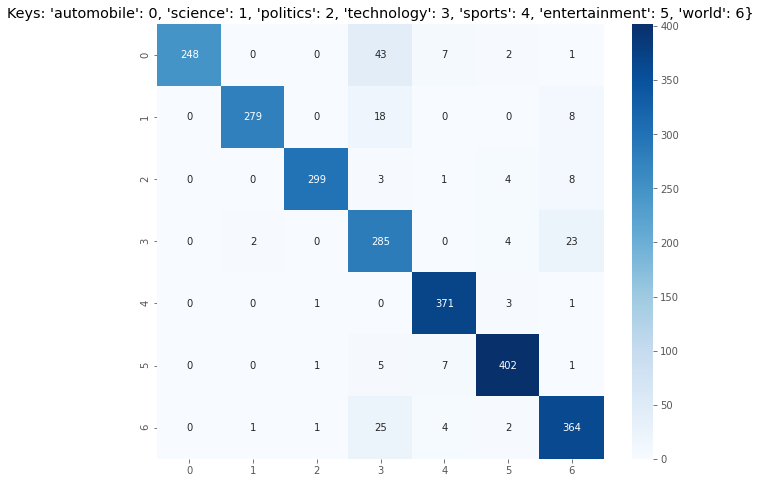

In [20]:
plt.figure(figsize=[10,8])
sns.heatmap(conf_matrix, annot = True, fmt ='d',cmap = 'Blues')
plt.title("Keys: 'automobile': 0, 'science': 1, 'politics': 2, 'technology': 3, 'sports': 4, 'entertainment': 5, 'world': 6}");

Those are pretty darn good results. The biggest problems, and not that big btw, are with the techonology news. It confuses 28 of actually 'automobile' news with techonology. 38 actual 'techonology news' are classified as 'world' and 26 actual 'world' are classified as techonology. But those are very small amount of mistakes compared to the correctly classified. 

## Save model

Let's create a pipeline that will ease the model when serves in production.

In [34]:
pipe = Pipeline([('vectorizer', TfidfVectorizer()), ('nb', ComplementNB())])
pipe.fit(df['news_article'] , df['news_category'] )

Pipeline(steps=[('vectorizer', TfidfVectorizer()), ('nb', ComplementNB())])

In [35]:
txt = 'Chelsea is the best team in England and they are going to win Champions League this season as well'
txt = clean_text(txt)
txt = remove_stopwords(txt)
txt

'chelsea best team england going win champions league season well'

In [36]:
pipe.predict([txt])

array([4])

In [37]:
txt = 'I just read about the Facebook newest AI convolutional network. It is super cool and cant wait to test on dataset'
txt = clean_text(txt)
txt = remove_stopwords(txt)
txt

'read facebook newest ai convolutional network super cool cant wait test dataset'

In [38]:
pipe.predict([txt])

array([3])

Cool. Both 'txt' variables were guessed correctly. We could pass clean_text and remove_stopwords functions to the pipeline but I prefer it this way. When we deploy we might have to change these so they will be in the app so we can control and change them eventually.

In [39]:
import pickle
save_classifier = open("nb_topic_classifier.pickle","wb")
pickle.dump(pipe, save_classifier)
save_classifier.close()